In [1]:
import numpy as np
import networkx as nx
import numpy.random as rnd
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def plot(matX, SOM=None):
    xs = matX[0]
    ys = matX[1]
    zs = matX[2]
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(xs, ys, zs, marker='o', color='black', s=30)
    
    if(SOM != None):
        for e in SOM.edges:
            pnt1 = SOM.node[e[0]]['w']
            pnt2 = SOM.node[e[1]]['w']
            xs = np.array([pnt1[0], pnt2[0]])
            ys = np.array([pnt1[1], pnt2[1]])
            zs = np.array([pnt1[2], pnt2[2]])
            plt.plot(xs, ys, zs, marker='o', color='blue', markersize=15)
            
    plt.savefig('SOM_')
    plt.show()

In [3]:
def initGridSOM(matX, kx, ky):
    G = nx.generators.lattice.grid_2d_graph(kx, ky) # kx * ky is the number of SOM neurons
    G = nx.convert_node_labels_to_integers(G)
    m, n = matX.shape
    smpl = rnd.choice(n, kx*ky, replace=False) 
    for i, v in enumerate(G):
        G.node[v]['w'] = matX[:,smpl[i]] 
    return G

In [50]:
def initRingSOM(matX, k):
    G = nx.generators.lattice.grid_2d_graph(k, 1, periodic=True) 
    G = nx.convert_node_labels_to_integers(G)
    m, n = matX.shape
    smpl = rnd.choice(n, k, replace=False) 
    for i, v in enumerate(G):
        G.node[v]['w'] = matX[:,smpl[i]] 
    return G

In [5]:
def getDataMat(path):
    data = pd.read_csv(path)
    return np.array(data).T

In [6]:
TG = nx.generators.lattice.grid_2d_graph(3,4)
TG.node

NodeView(((0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (1, 3), (2, 0), (2, 1), (2, 2), (2, 3)))

/Users/edwinyang/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


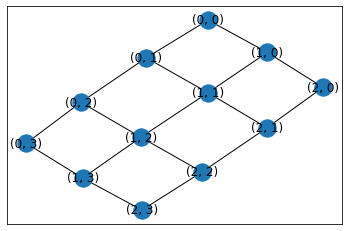

In [7]:
nx.draw_networkx(TG, with_labels=True)

In [8]:
TG = nx.convert_node_labels_to_integers(TG)
TG.node

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11))

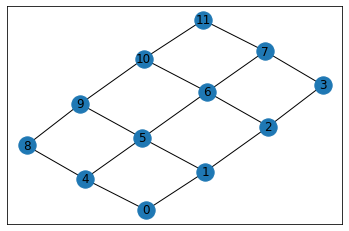

In [9]:
nx.draw_networkx(TG, with_labels=True)

In [10]:
test = rnd.choice(100, 12, replace=False)
print(test)

[86 25 61  6 73 95 15 43 30 52  9 56]


In [11]:
a = np.arange(120).reshape(3,40)
print(a[:, 0])

[ 0 40 80]


In [12]:
G = initGridSOM(a, 2,4)

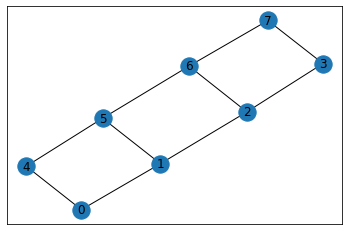

In [13]:
nx.draw_networkx(G, with_labels=True)

In [14]:
G.node[0]['w']

array([11, 51, 91])

In [15]:
matX_1 = getDataMat('./q3dm1-path1.csv')

In [16]:
matX_2 = getDataMat('./q3dm1-path2.csv')

In [17]:
SOM1 = initGridSOM(matX_1, 4, 5)

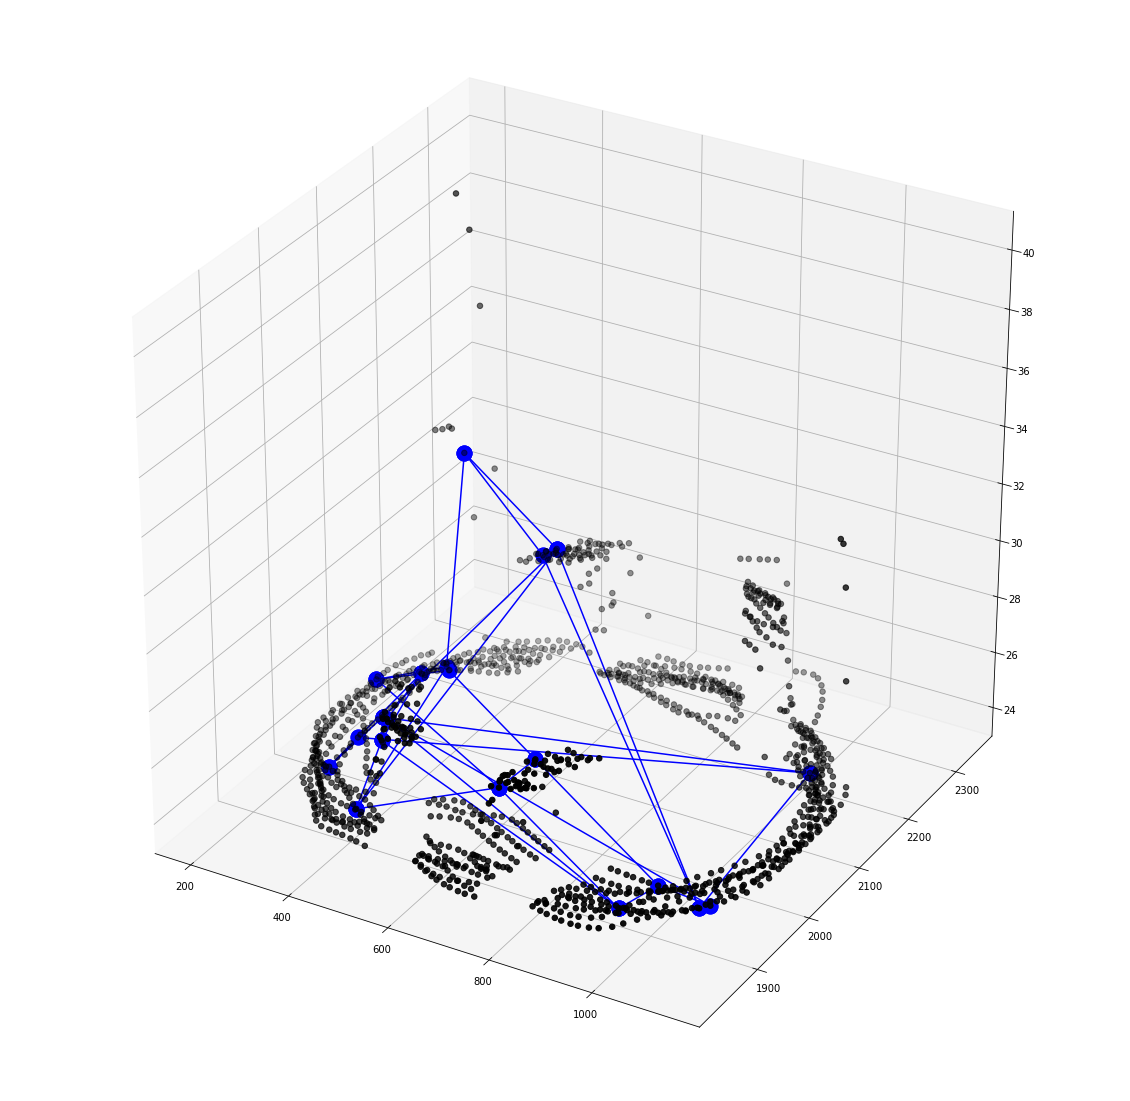

In [18]:
plot(matX_1, SOM1)

In [19]:
def trainSOMV2(matX, G, tmax=1000, sigma0=1., eta0=1.): 
    '''
    a numpythonic version of online SOM training
    '''
    m, n = matX.shape
    matW = np.vstack([G.node[v]['w'] for v in G.nodes()]).T 
    m, k = matW.shape
    matD = np.asarray(nx.floyd_warshall_numpy(G))**2 
    smpl = rnd.randint(0, n, size=tmax)
    for t in range(tmax):
    # NOTE: for all of the below to work, we must reshape the sampled column of X 
        vecX = matX[:,smpl[t]].reshape(m,1)
        b = np.argmin(np.sum((matW - vecX)**2, axis=0)) 
        eta = eta0 * (1. - t/tmax)
        sigma = sigma0 * np.exp(-t/tmax)
        vecH = np.exp(-0.5 * matD[b,:]/sigma**2) 
        matW += eta * vecH * (vecX - matW)
    for i, v in enumerate(G):
        G.node[v]['w'] = np.ravel(matW[:,i])
    return G

In [20]:
def trainSOM(matX, G, tmax=5000, sigma0=1., eta0=1.): 
    m, n = matX.shape
    # compute matrix of squared path length distances between neurons 
    # NOTE: networkx returns a numpy matrix, but we want a numpy array 
    # because this allows for easy squaring of its entries
    #matM = nx.floyd_warshall_numpy(G)
    #print(matM)
    matD = np.asarray(nx.floyd_warshall_numpy(G))**2
    #print(matD)
    # a list of tmax random indices into the columns of matrix X
    smpl = rnd.randint(0, n, size=tmax)
    for t in range(tmax):
        # sample a point x, i.e. a column of matrix X 
        vecX = matX[:,smpl[t]]
        # determine the best matching unit
        b = np.argmin([np.sum((G.node[v]['w'] - vecX)**2) for v in G]) 
        # update the learning rate
        eta = eta0 * (1. - t/tmax)
        # update the topological adaption rate
        sigma = sigma0 * np.exp(-t/tmax)
    # update all weights
    for i, v in enumerate(G):
        # evaluate neighborhood function
        h = np.exp(-0.5 * matD[b,i] / sigma**2) 
        G.node[v]['w'] += eta * h * (vecX - G.node[v]['w'])
    return G

In [22]:
SOM1_2 = trainSOMV2(matX_1, SOM1, tmax=8000)

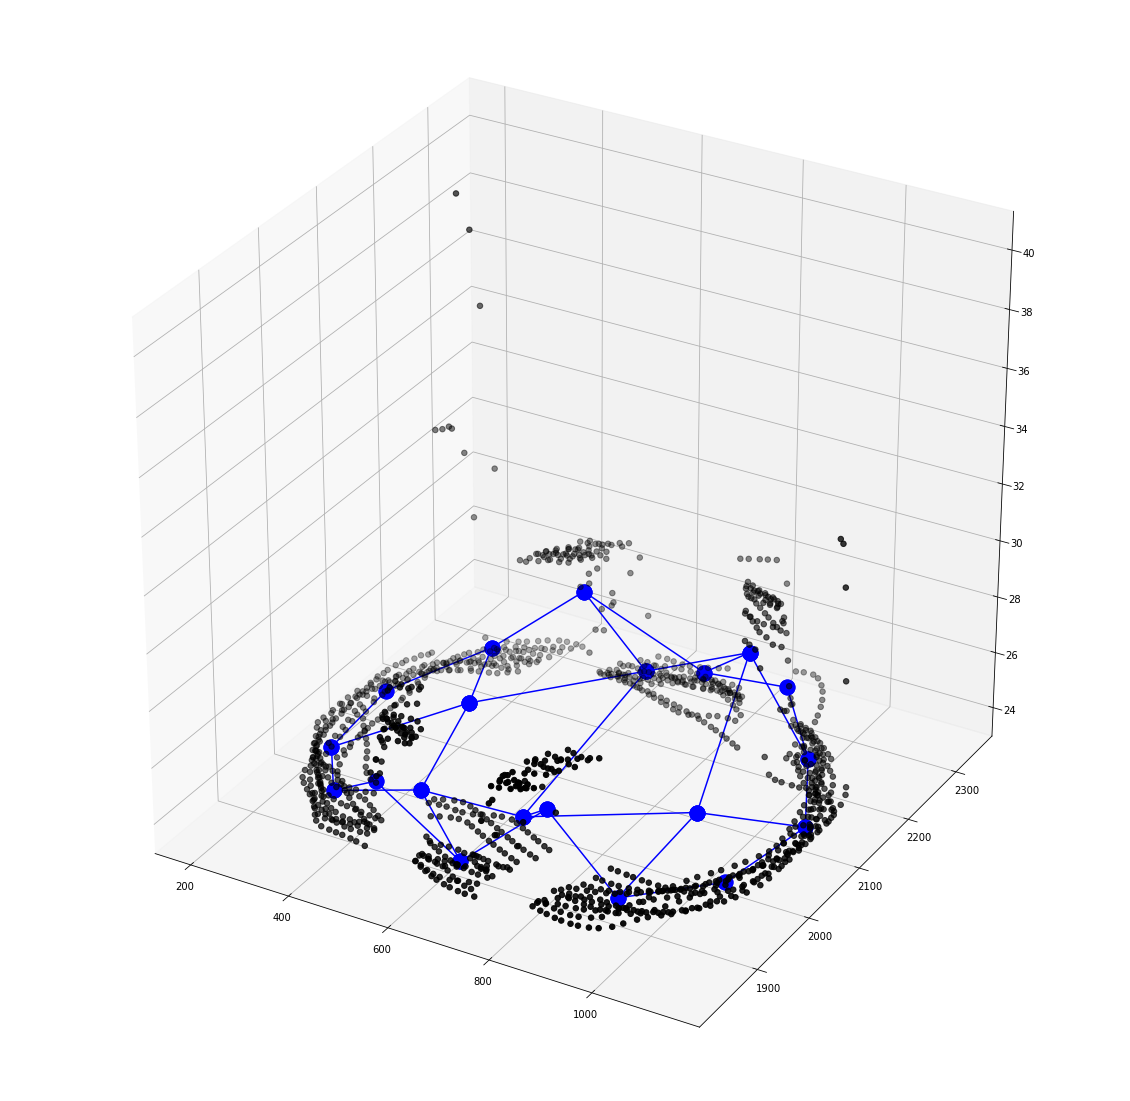

In [23]:
plot(matX_1, SOM1)

In [24]:
SOM2 = initRingSOM(matX_1, 20)

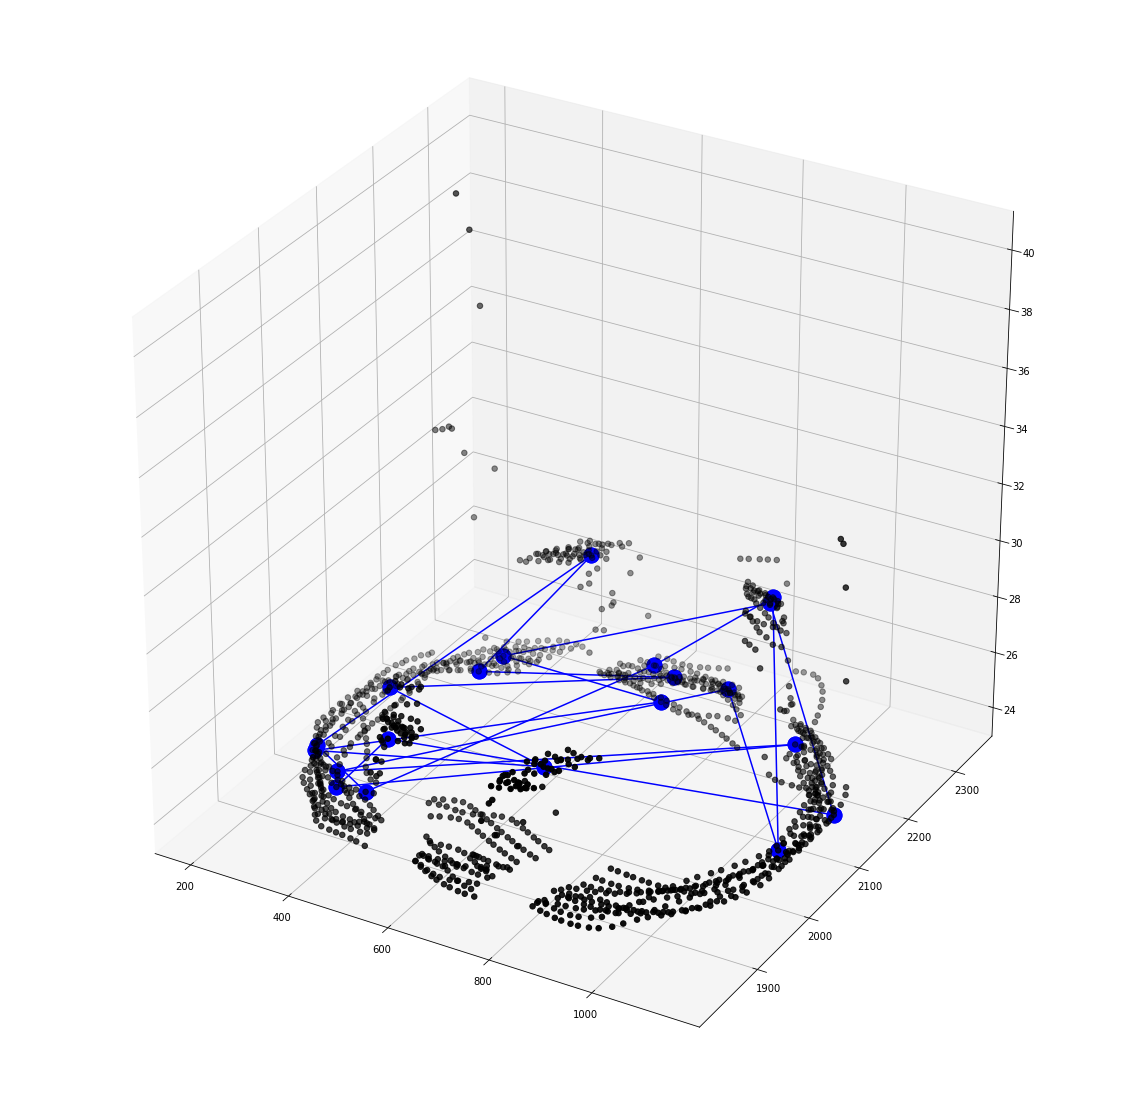

In [25]:
plot(matX_1, SOM2)

In [31]:
SOM2 = trainSOMV2(matX_1, SOM2, tmax=5000)

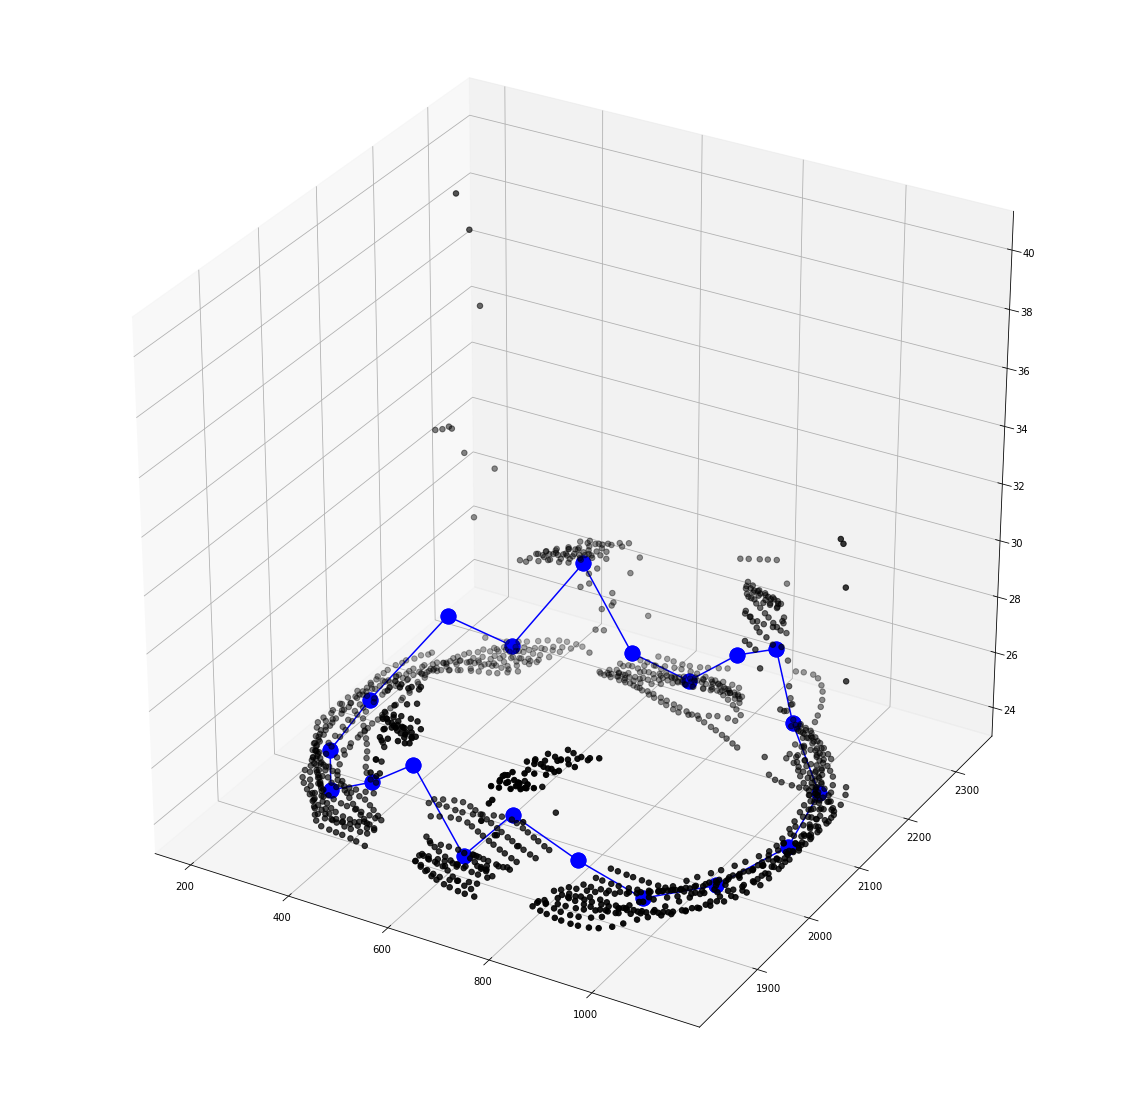

In [32]:
plot(matX_1, SOM2)

In [33]:
matX_2 = getDataMat('./q3dm1-path2.csv')

In [34]:
SOM2_2 = trainSOMV2(matX_2, SOM2)

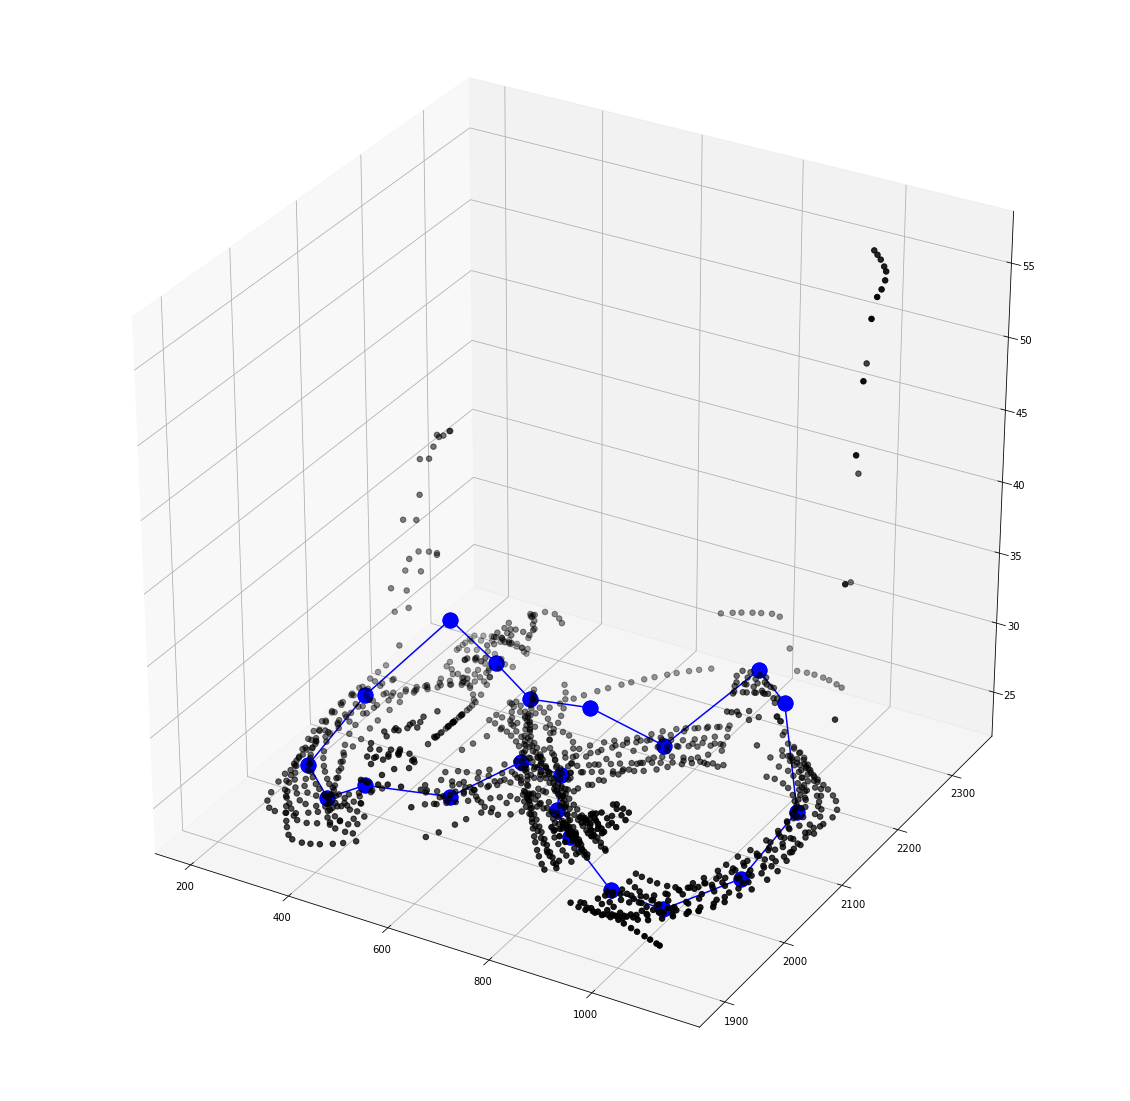

In [35]:
plot(matX_2, SOM2_2)

In [36]:
SOM2_2 = trainSOMV2(matX_2, SOM2_2)

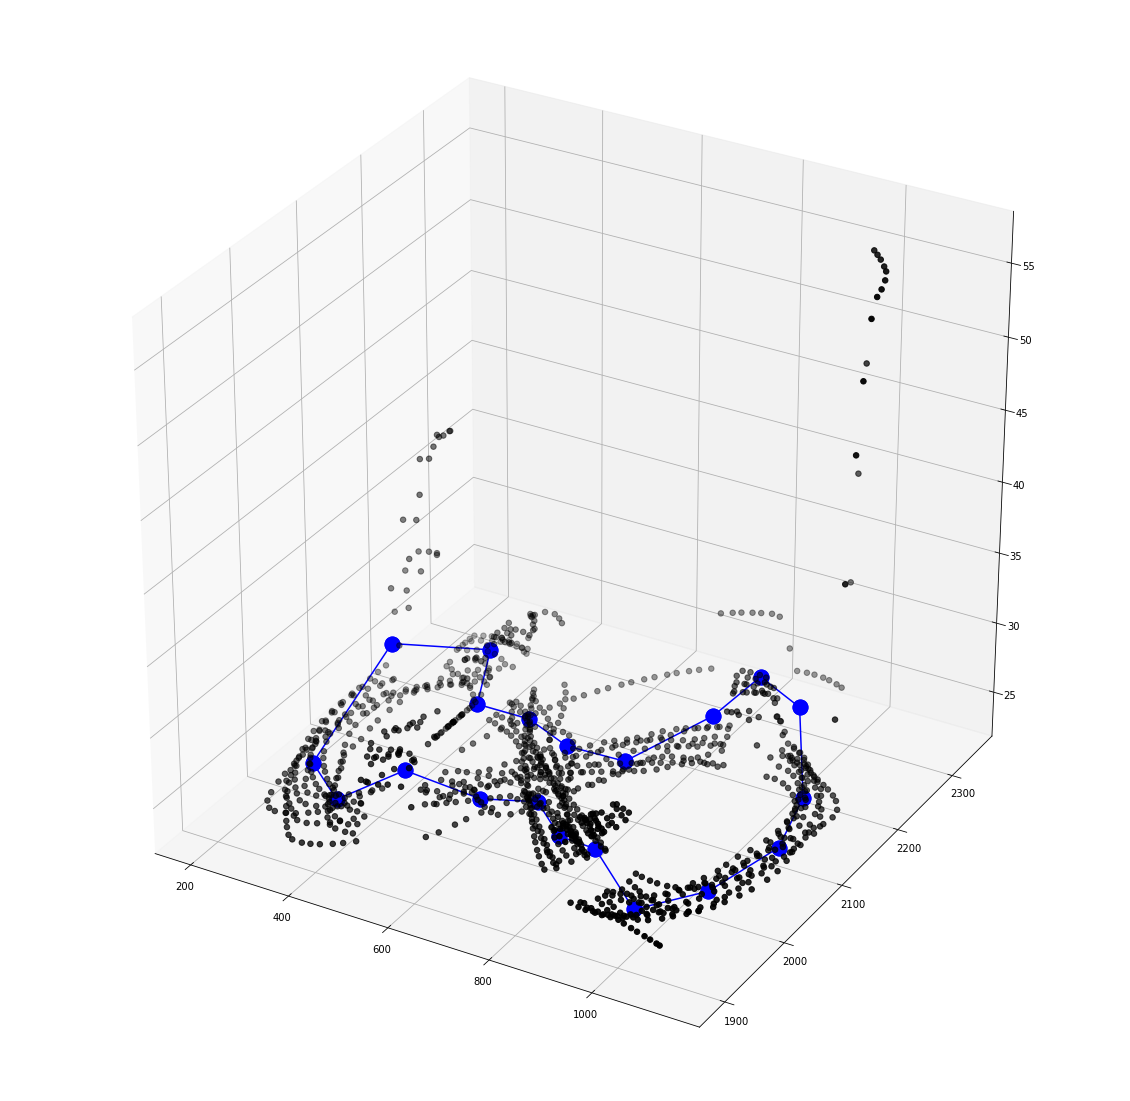

In [37]:
plot(matX_2, SOM2_2)

# Double Ring SOM

In [63]:
def initDoubleRingSOM(matX, k): # k is the number of a single ring, 2*k in total

    G = nx.generators.lattice.grid_2d_graph(k, 1, periodic=True) 
    G = nx.convert_node_labels_to_integers(G)
    
    H = nx.generators.lattice.grid_2d_graph(k, 1, periodic=True) 
    H = nx.convert_node_labels_to_integers(H)
    
    k = 2 * k
    
    C = nx.disjoint_union(G, H)
    C.add_edge(0, k-1)
    
    m, n = matX.shape
    smpl = rnd.choice(n, k, replace=False) 
    for i, v in enumerate(C):
        C.node[v]['w'] = matX[:,smpl[i]] 
    return C

/Users/edwinyang/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


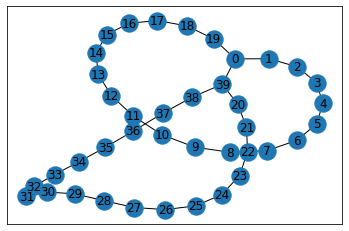

In [48]:
k = 20
G = nx.generators.lattice.grid_2d_graph(k, 1, periodic=True) 
G = nx.convert_node_labels_to_integers(G)
    
H = nx.generators.lattice.grid_2d_graph(k, 1, periodic=True) 
H = nx.convert_node_labels_to_integers(H)

C = nx.disjoint_union(G, H)
C.add_edge(0, 2*k-1)
nx.draw_networkx(C, with_labels=True)

In [64]:
SOM3 = initDoubleRingSOM(matX_2, 10)

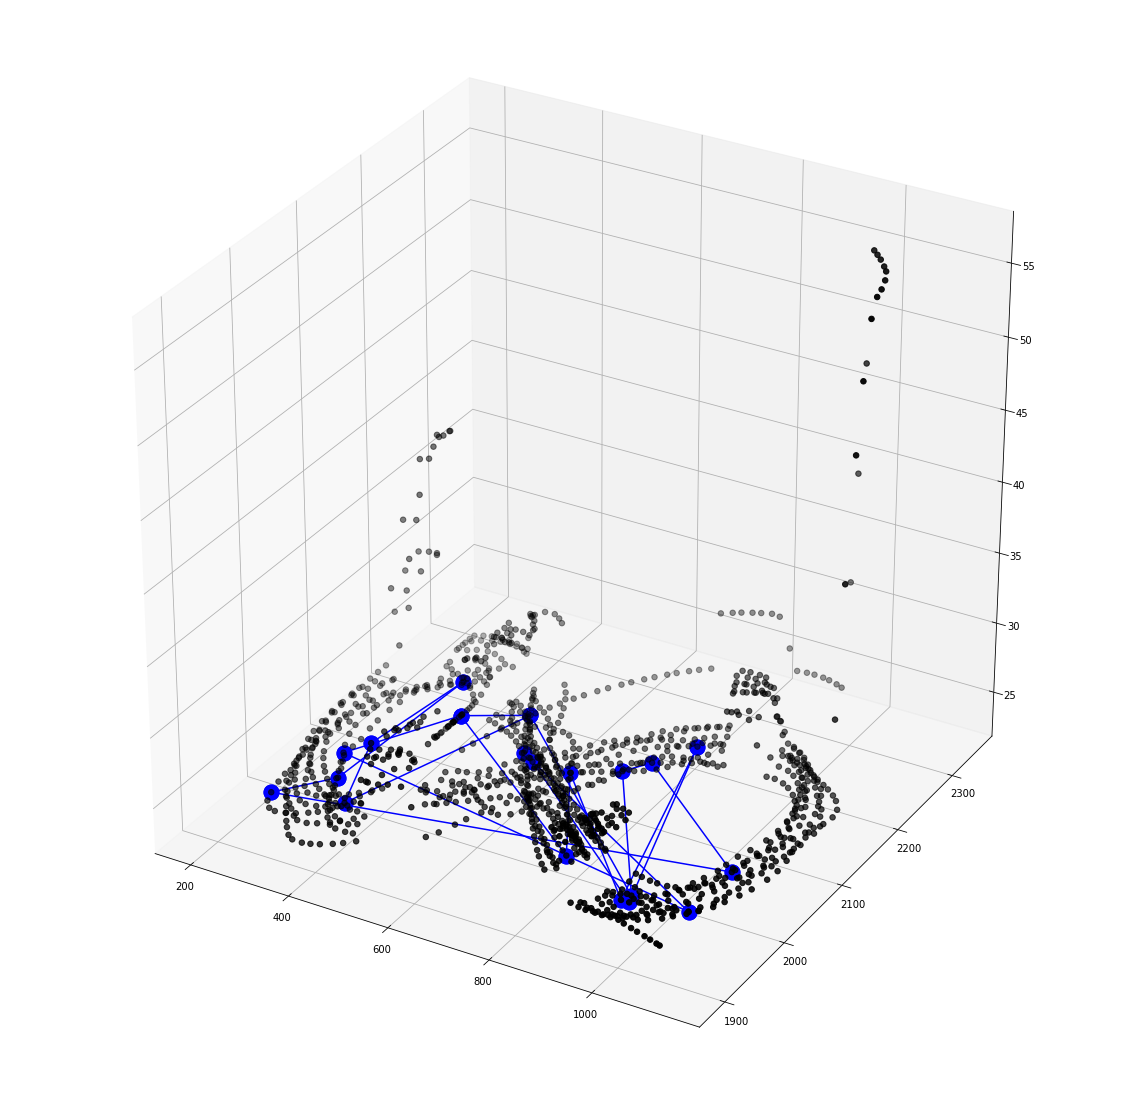

In [65]:
plot(matX_2, SOM3)

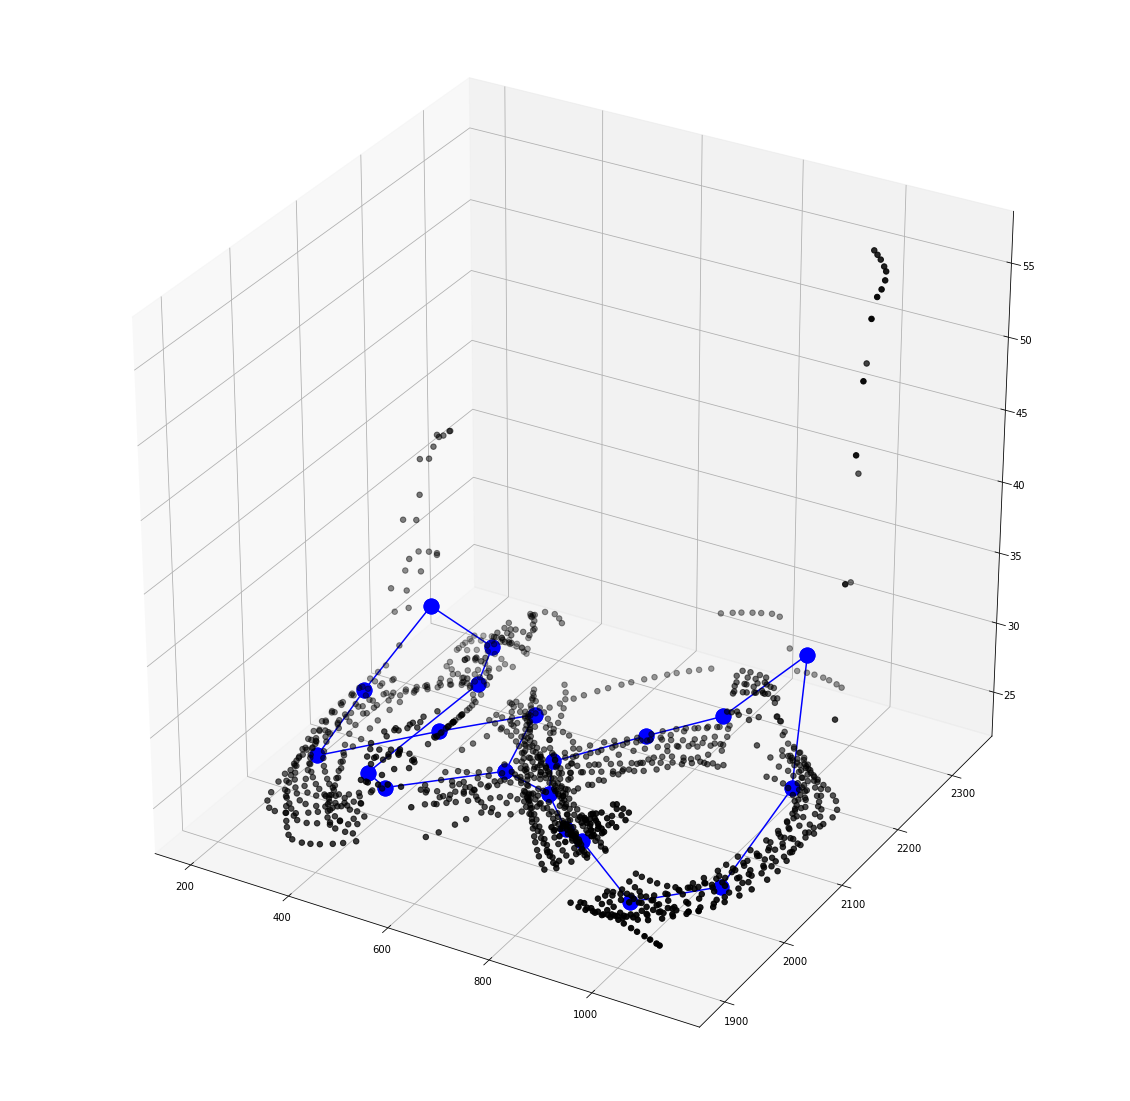

In [66]:
SOM3_1 = trainSOMV2(matX_2, SOM3)
plot(matX_2, SOM3_1)

In [69]:
SOM3_1 = trainSOMV2(matX_2, SOM3_1, tmax=8000)

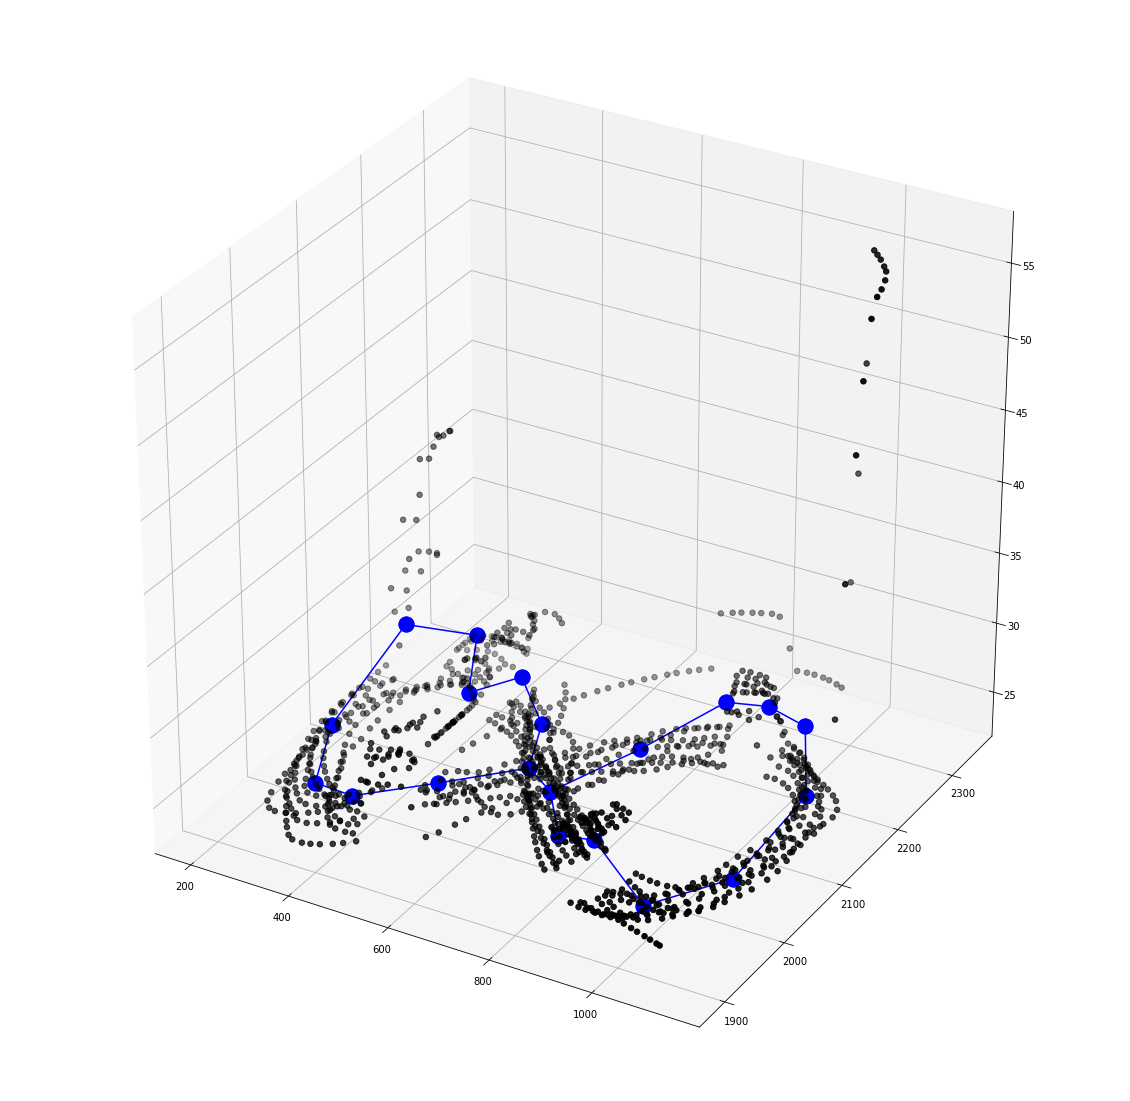

In [70]:
plot(matX_2, SOM3_1)